<h1>Extract salt and temp from ROMS file on MET Norway thredds</h1>
General example on how to extract data from ROMS model on MET Norway thredds server

In [42]:
import netCDF4
import numpy as np
import datetime
import sys
import matplotlib.pyplot as plt
import roppy # https://github.com/bjornaa/roppy

Define code used in this example:

In [43]:
def roms_latlon2xy(f,lat,lon,roundvals=True):
    a = abs( f.variables['lat_rho'][:]-lat ) + abs( f.variables['lon_rho'][:]-lon )
    y_coord, x_coord = np.unravel_index(a.argmin(), a.shape)
    if roundvals:
        x_coord = int(np.round(x_coord))
        y_coord = int(np.round(y_coord))
    return x_coord, y_coord

def BFS(start_i, start_j, arr, crit=1):
    """
    Code from josteinb@met.no

    desc:
        Breadth first search function to find index of nearest
        point with crit value (default crit=1 for finding ROMS
        wet-point in mask)
    args:
        - start_i: Start index of i
        - start_j: Start index of j
        - arr: grid with data
        - crit: value to search for (deafult unmasked point)
    return:
        - index of point
    """
    dirs    = [(1,0), (-1,0), (0,1),(0,-1)]
    visited = set()
    q       = [(start_i, start_j)]    # init queue to start pos
    count   = 0
    arrays  = list()  # for storing frames if plotting
    # while something in queue
    while q:
        current = q.pop(0)      # pop the first in waiting queue
        # if we have visited this before
        if current in visited:
            continue
        visited.add(current)    # Add to set of visited
        # If not in border list
        # Test if this is land, if true go to next in queue, else return idx
        if arr[current[0], current[1]] == crit:
            return current[0], current[1]
        count += 1      #updates the count
        # Loop over neighbours and add to queue
        for di, dj in dirs:
            new_i = current[0]+di
            new_j = current[1]+dj
            q.append((new_i, new_j))

def get_z(grd):
    import roppy
    h      = grd.variables['h']
    C      = grd.variables['Cs_r'][:]
    Cw     = grd.variables['Cs_w'][:]
    Hc     = grd.variables['hc'].getValue()
    vtrans = grd.variables['Vtransform'].getValue()
    z_rho  = roppy.sdepth(h, Hc, C, Vtransform=vtrans)
    z_w    = roppy.sdepth(h, Hc, Cw, Vtransform=vtrans)
    return z_rho, z_w

"User input" should be put in this box:

In [44]:
date = "20230928"  # date is needed for correct file name
filename = f"https://thredds.met.no/thredds/dodsC/fjordos/operational_archive/complete_archive/ocean_his.nc_{date}00"

nc       = netCDF4.Dataset(filename)
# for var_name, var in nc.variables.items():
#     print(f"Variable Name: {var_name}")
#     print(f"Dimensions: {var.dimensions}")
#     print(f"Shape: {var.shape}")
#     print(f"Data Type: {var.dtype}")
#     print(f"Attributes: {var.__dict__}")  # Print variable attributes
#     print("-" * 30)
lat      = [59.88, 59.88, 59.86, 59.86] 
lon      = [10.65, 10.65, 10.70, 10.70]
name     = ['Nesoddetangen_example','Nesoddetangen_example','Nesoddetangen_example','Nesoddetangen_example']
times    = [datetime.datetime(2023,9,28,7),
            datetime.datetime(2023,9,28,13),
            datetime.datetime(2023,9,28,8),
            datetime.datetime(2023,9,28,12)]  # Format year, month, day, hour. Date needs to be the same as  "date" above.
loc      = ["A", "A", "C", "C"]

In [45]:
# Check all arrays length:
if not (len(lat) == len(lon) == len(name) == len(times)):   
    print('Error in array lengths')
    raise()

In [46]:
# Read vertical layers depth:
z_rho, z_w = get_z(nc)

Looping over all stations defined above and printing the salt and temp, and plot the data in a simple fashion:

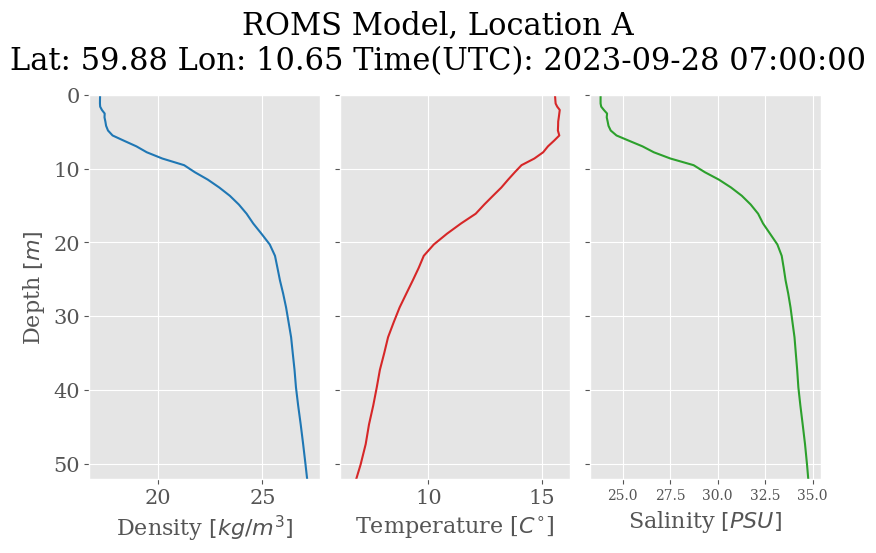

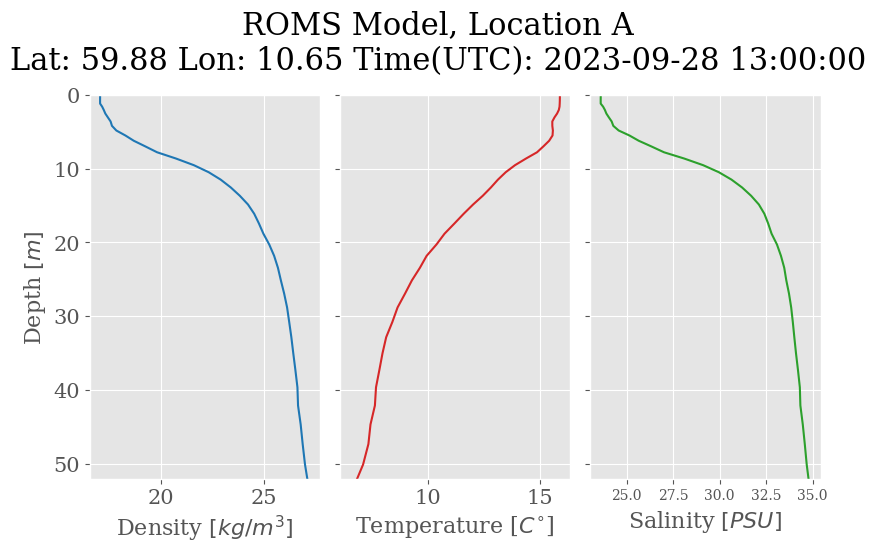

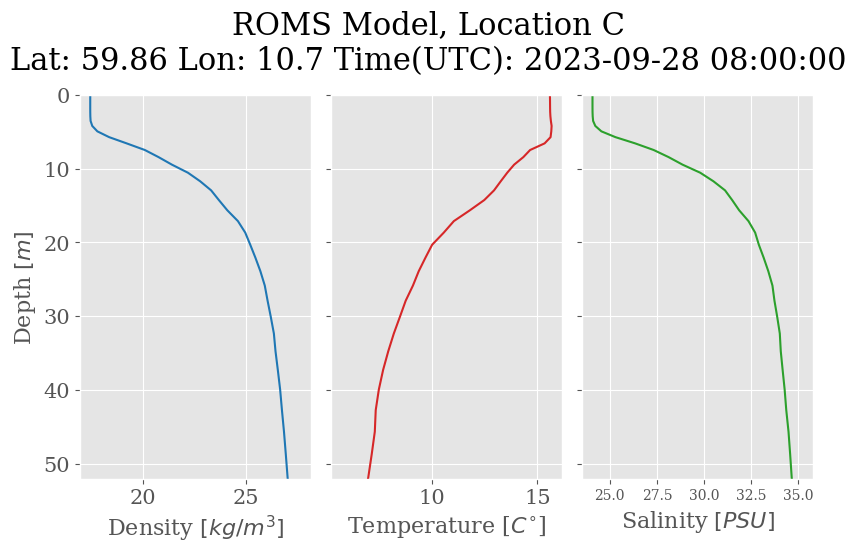

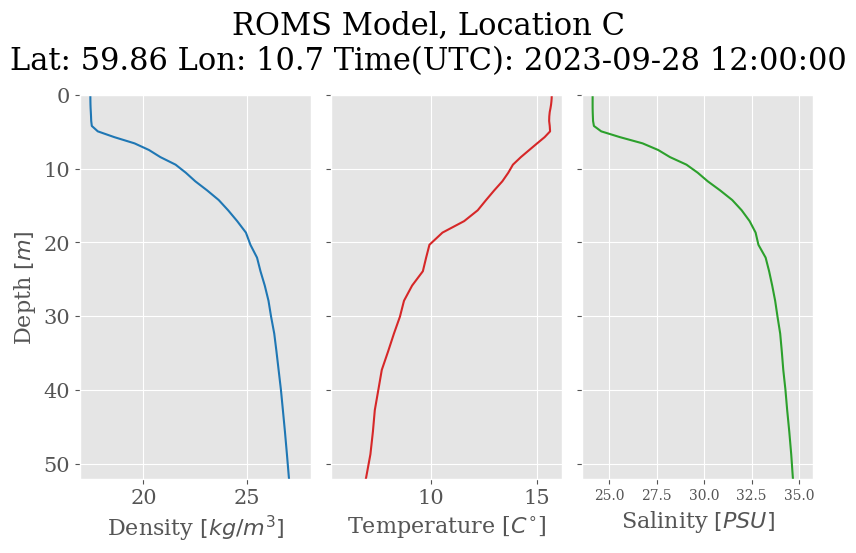

In [47]:

# Loop over all stations:
for i in range(len(name)):
    x, y = roms_latlon2xy(nc, lat[i], lon[i]) # find x and y indexes
    t    = np.where(netCDF4.num2date(nc.variables['ocean_time'][:], nc.variables['ocean_time'].units) == times[i])[0][0] # find time index
    mask = nc.variables['mask_rho'][:]
    if mask[y,x] == 0:
        print('Position is on land, will find nearest wet gridpoint')
        y, x = BFS(y,x,mask)
    salt = nc.variables['salt'][t,:,y,x]
    temp = nc.variables['temp'][t,:,y,x]

    # print('user defined lat: {}, lon: {}'.format(lat[i], lon[i]))
    # print('model lat: {}, lon: {}'.format(nc.variables['lat_rho'][y,x], nc.variables['lon_rho'][y,x]))
    # print('{}: {}, {} (x, y), salt: {}, temp: {}'.format(name[i], x, y, salt, temp))
    # print('-------------------------')
    # plt.plot(salt, z_rho[:,y,x], label='salt model {}'.format(name[i]))
    # plt.plot(temp, z_rho[:,y,x], label='temp model {}'.format(name[i]))
#########################
# get density using gsw 
    import gsw
    rho = gsw.rho(salt, temp, 0)

########################
    import matplotlib

    matplotlib.rcParams.update({
    'font.size': 18,          # Adjust the font size as needed
    'font.family': 'serif'   # Choose the font family (e.g., 'serif', 'sans-serif', 'monospace')
    })
    plt.style.use("ggplot")

    
    # Create a figure with three subplots in one row, sharing the same y-axis
    a=.8
    fig, axes = plt.subplots(1, 3, figsize=(10*a, 7*a), sharey=True)

    font_s = 16

    axes[0].tick_params(axis='both', labelsize=font_s-1)
    axes[1].tick_params(axis='both', labelsize=font_s-1)
    # axes[2].tick_params(axis='both', labelsize=font_s-1)

    # Plot Density vs. Depth
    axes[0].plot(rho-1000, -z_rho[:,y,x], color = "tab:blue")
    axes[0].set_xlabel('Density $[kg/m^3]$', fontsize=font_s)
    # axes[0].set_ylabel('Depth')
    axes[0].invert_yaxis()

    # Plot Temperature vs. Depth
    axes[1].plot(temp, -z_rho[:,y,x], color="tab:red")
    axes[1].set_xlabel('Temperature [$C^{\\circ}$]', fontsize=font_s)
    # axes[1].invert_yaxis()

    # Plot Salinity vs. Depth
    axes[2].plot(salt, -z_rho[:,y,x], color="tab:green")
    axes[2].set_xlabel('Salinity $[PSU]$', fontsize=font_s)
    # axes[2].invert_yaxis()

    # Add a main title
    plt.suptitle(f"ROMS Model, Location {loc[i]}\nLat: {lat[i]} Lon: {lon[i]} Time(UTC): {times[i]}", fontsize=22)

    # Adjust spacing between subplots
    plt.tight_layout()

    # Share y-axis labels and set a common y-axis label for the row of subplots
    axes[0].set_ylabel('Depth $[m]$', fontsize = font_s)
    axes[0].set_ylim(52, 0) 


    ##############
    # Show the plots
    plt.savefig(f"figures/model_profiles/model_profiles_{loc[i]}_{str(times[i]).replace('-', '_').replace(' ', '_').replace(':00', '')}.png", dpi=300, bbox_inches='tight')
#########################
# plt.legend()
plt.show()